# Loade libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch.unitroot import ADF
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Data exploration

In [2]:
data=pd.read_csv('TSLA.csv')
data.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2019-09-30,48.796001,47.222000,48.599998,48.174000,29399000.0,48.174000
1,2019-10-01,49.189999,47.826000,48.299999,48.938000,30813000.0,48.938000
2,2019-10-02,48.930000,47.886002,48.658001,48.625999,28157000.0,48.625999
3,2019-10-03,46.896000,44.855999,46.372002,46.605999,75422500.0,46.605999
4,2019-10-04,46.956001,45.613998,46.321999,46.285999,39975000.0,46.285999


In [3]:
data.shape

(639, 7)

In [4]:
data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,639.000000,639.000000,639.000000,639.000000,6.390000e+02,639.000000
mean,543.362885,517.883537,531.004088,531.298030,4.819130e+07,531.298030
std,340.837426,325.395864,333.534448,333.362040,3.579030e+07,333.362040
min,46.896000,44.855999,45.959999,46.285999,9.800600e+06,46.285999
25%,170.258003,162.379997,167.349998,164.783005,2.392195e+07,164.783005
50%,620.409973,595.500000,603.880005,605.130005,3.448900e+07,605.130005
75%,796.584991,767.744995,779.445007,781.304993,6.329725e+07,781.304993
max,1243.489990,1217.000000,1234.410034,1229.910034,3.046940e+08,1229.910034


<Axes: >

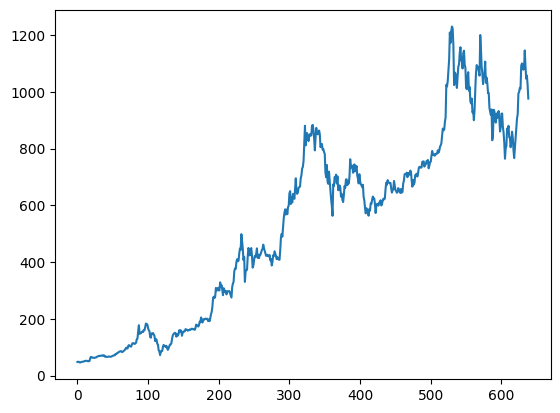

In [5]:
data['Adj Close'].plot()

In [6]:
adfuller(data['Adj Close'])  # ADF analysis

(-1.0171172775180486,
 0.7469700840885269,
 0,
 638,
 {'1%': -3.440641231176813,
  '5%': -2.8660808067889976,
  '10%': -2.569188186240308},
 5732.071130853123)

<Axes: >

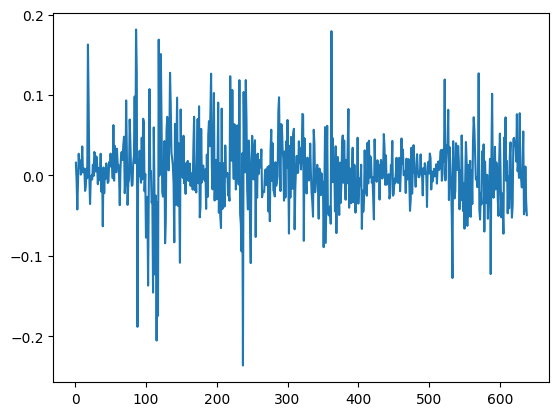

In [7]:
np.log(data['Adj Close']).diff().plot()

In [8]:
data1=data['Adj Close'].diff(1).dropna()

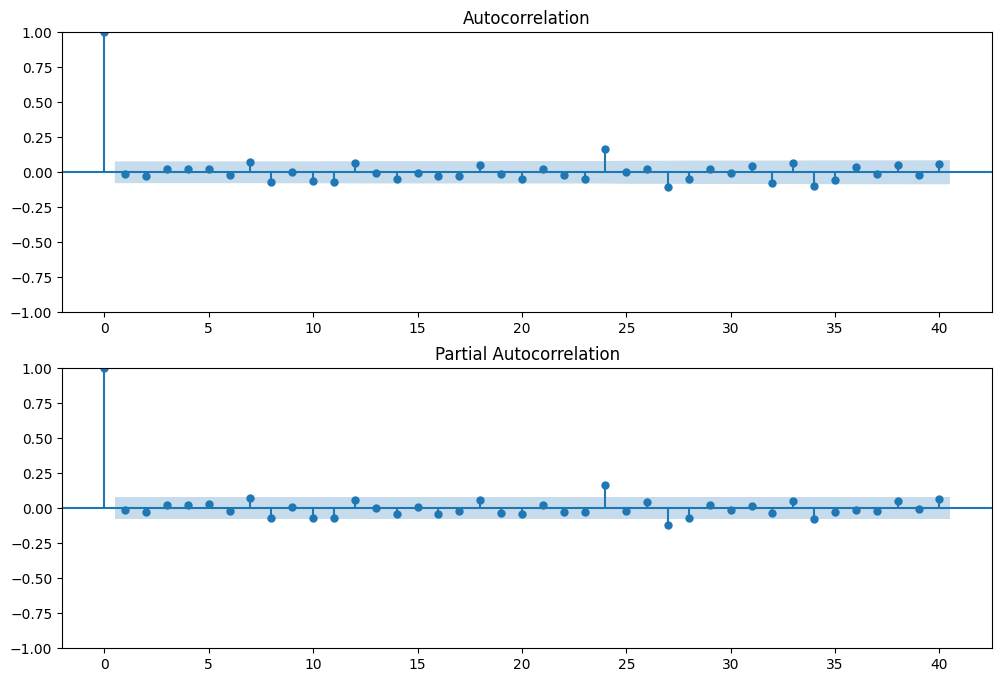

In [9]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data1, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data1, lags=40, ax=ax2)


In [10]:

adfuller(data1)   # ADF analysis

(-25.397962901192685,
 0.0,
 0,
 637,
 {'1%': -3.44065745275905,
  '5%': -2.8660879520543534,
  '10%': -2.5691919933016076},
 5724.835301003357)

# Data pre-processing

In [13]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [14]:

scaler = StandardScaler()
data2=scaler.fit_transform(data1.values.reshape(-1,1))

scaler1 = StandardScaler()
data3=scaler1.fit_transform(data['Adj Close'].values.reshape(-1,1))

In [160]:
new_data=pd.DataFrame(data3,columns=['diff'])
new_data

,diff
0,-1.450383
1,-1.448089
2,-1.449026
3,-1.455090
4,-1.456051
...,...
634,1.681057
635,1.544462
636,1.578986
637,1.483610


In [369]:
newdata = series_to_supervised(new_data, 1, 10)
newdata.head()

,var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9)
1,-1.450383,-1.448089,-1.449026,-1.455090,-1.456051,-1.452274,-1.450875,-1.448185,-1.448059,-1.446168,-1.440722
2,-1.448089,-1.449026,-1.455090,-1.456051,-1.452274,-1.450875,-1.448185,-1.448059,-1.446168,-1.440722,-1.440163
3,-1.449026,-1.455090,-1.456051,-1.452274,-1.450875,-1.448185,-1.448059,-1.446168,-1.440722,-1.440163,-1.439047
4,-1.455090,-1.456051,-1.452274,-1.450875,-1.448185,-1.448059,-1.446168,-1.440722,-1.440163,-1.439047,-1.437714
5,-1.456051,-1.452274,-1.450875,-1.448185,-1.448059,-1.446168,-1.440722,-1.440163,-1.439047,-1.437714,-1.440728


In [370]:
X = newdata.iloc[:,:-1].values
y = newdata.iloc[:,-1].values

train_size = int(len(newdata) * 0.8)
valid_size = int(len(newdata) * 0.192)
test_size = len(newdata) - train_size - valid_size



X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(valid_size + test_size)/len(newdata),shuffle=False)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(valid_size + test_size), shuffle=False)

X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_valid, y_valid = torch.tensor(X_valid, dtype=torch.float32), torch.tensor(y_valid, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)


In [371]:
batch_size=64
X_train = X_train.unsqueeze(1)
X_valid = X_valid.unsqueeze(1)
X_test = X_test.unsqueeze(1)
# 重新创建数据加载器
train_loader =  torch.utils.data.DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
valid_loader =  torch.utils.data.DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=False)
test_loader =  torch.utils.data.DataLoader(TensorDataset(X_test, y_test), batch_size=1, shuffle=False)

# Define models

In [381]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, model_type="RNN"):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.model_type=model_type
        if model_type == "RNN":
            self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True)
        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 128)
        self.fc1 = nn.Linear(128, output_dim)
        self.drop=nn.Dropout(p=0.2)
        self.relu=nn.ReLU()
    def forward(self, x):
        if self.model_type=='LSTM':
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
            out, _= self.rnn(x)
        else:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
            out, hn = self.rnn(x, h0.detach())
        out = self.fc(out[:, -1, :])
        #out=self.relu(out)
        #out=self.drop(out)
        out = self.fc1(out)
        return out


In [393]:

input_dim = X_train.shape[-1]
hidden_dim = 100
layer_dim = 1
output_dim = 1


rnn_model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim, model_type="RNN")
lstm_model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim, model_type="LSTM")
gru_model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim, model_type="GRU")

In [159]:
rnn_model 

RNNModel(
  (rnn): RNN(3, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=1, bias=True)
)

In [92]:
lstm_model 

RNNModel(
  (rnn): LSTM(2, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [93]:
gru_model

RNNModel(
  (rnn): GRU(2, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

# Model comparasion

In [383]:

def train_and_validate(model, train_loader, valid_loader, num_epochs):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)


    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for data, target in train_loader:

            optimizer.zero_grad()

            output = model(data)

            loss = criterion(output, target.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        

        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for data, target in valid_loader:
                output = model(data)
                loss = criterion(output, target.unsqueeze(1))
                valid_loss += loss.item() * data.size(0)
        

        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_losses.append(valid_loss)
        print('Train loss is '+str(train_loss)+' at epoch: '+str(epoch))
        print('Valid loss is '+str(valid_loss)+' at epoch: '+str(epoch))
    return train_losses, valid_losses


num_epochs =100

rnn_train_losses, rnn_valid_losses = train_and_validate(rnn_model, train_loader, valid_loader, num_epochs)

Train loss is 0.4847421731733186 at epoch: 0
Valid loss is 0.2526012788216273 at epoch: 0
Train loss is 0.04319596630576665 at epoch: 1
Valid loss is 0.06283709680040678 at epoch: 1
Train loss is 0.014301996705886976 at epoch: 2
Valid loss is 0.07933176532387734 at epoch: 2
Train loss is 0.03363389844004487 at epoch: 3
Valid loss is 0.06042038351297378 at epoch: 3
Train loss is 0.018082248017369636 at epoch: 4
Valid loss is 0.16108968605597815 at epoch: 4
Train loss is 0.01805124499012992 at epoch: 5
Valid loss is 0.06319987227519354 at epoch: 5
Train loss is 0.013240233977893682 at epoch: 6
Valid loss is 0.09053727636734644 at epoch: 6
Train loss is 0.014533779943995104 at epoch: 7
Valid loss is 0.0583875298500061 at epoch: 7
Train loss is 0.0098969527218439 at epoch: 8
Valid loss is 0.08946186304092407 at epoch: 8
Train loss is 0.01163112374381801 at epoch: 9
Valid loss is 0.060147084295749664 at epoch: 9
Train loss is 0.00959868278543263 at epoch: 10
Valid loss is 0.0891485609114170

In [384]:

lstm_train_losses, lstm_valid_losses = train_and_validate(lstm_model, train_loader, valid_loader, num_epochs)

Train loss is 0.7430027612516468 at epoch: 0
Valid loss is 2.109591595331828 at epoch: 0
Train loss is 0.6053843682494836 at epoch: 1
Valid loss is 1.946579066912333 at epoch: 1
Train loss is 0.4236197591301935 at epoch: 2
Valid loss is 1.4738540569941203 at epoch: 2
Train loss is 0.15694085098284613 at epoch: 3
Valid loss is 0.7503124594688415 at epoch: 3
Train loss is 0.10513456496104569 at epoch: 4
Valid loss is 0.5178354561328888 at epoch: 4
Train loss is 0.023283559769747508 at epoch: 5
Valid loss is 0.295856045683225 at epoch: 5
Train loss is 0.017660514352506186 at epoch: 6
Valid loss is 0.11332082375884056 at epoch: 6
Train loss is 0.015279806228299027 at epoch: 7
Valid loss is 0.08787316704789798 at epoch: 7
Train loss is 0.011669846248366754 at epoch: 8
Valid loss is 0.13480534901221594 at epoch: 8
Train loss is 0.011838858458815257 at epoch: 9
Valid loss is 0.16786014785369238 at epoch: 9
Train loss is 0.010768772345443605 at epoch: 10
Valid loss is 0.18467427094777425 at ep

In [394]:
lstm_train_losses1, lstm_valid_losses1 = train_and_validate(lstm_model, train_loader, valid_loader, num_epochs)

Train loss is 0.6918632414777046 at epoch: 0
Valid loss is 1.6477163076400756 at epoch: 0
Train loss is 0.4224869855948044 at epoch: 1
Valid loss is 1.13282018105189 at epoch: 1
Train loss is 0.17582855068487865 at epoch: 2
Valid loss is 0.5404023071130116 at epoch: 2
Train loss is 0.026445956693343802 at epoch: 3
Valid loss is 0.1787501722574234 at epoch: 3
Train loss is 0.05427479410495898 at epoch: 4
Valid loss is 0.1492339367667834 at epoch: 4
Train loss is 0.01303176248860851 at epoch: 5
Valid loss is 0.15049258122841516 at epoch: 5
Train loss is 0.014911592923193637 at epoch: 6
Valid loss is 0.11005770787596703 at epoch: 6
Train loss is 0.012996486084494984 at epoch: 7
Valid loss is 0.08315442676345507 at epoch: 7
Train loss is 0.011025826830905723 at epoch: 8
Valid loss is 0.09101727257172267 at epoch: 8
Train loss is 0.010039515853961319 at epoch: 9
Valid loss is 0.11421349694331487 at epoch: 9
Train loss is 0.010052857426167364 at epoch: 10
Valid loss is 0.12125274737675985 at

In [385]:

gru_train_losses, gru_valid_losses = train_and_validate(gru_model, train_loader, valid_loader, num_epochs)


Train loss is 0.7138373783639601 at epoch: 0
Valid loss is 1.604496184984843 at epoch: 0
Train loss is 0.3384479681848295 at epoch: 1
Valid loss is 0.6557167033354442 at epoch: 1
Train loss is 0.038080812167102254 at epoch: 2
Valid loss is 0.07792636553446451 at epoch: 2
Train loss is 0.11082276763398179 at epoch: 3
Valid loss is 0.23531997203826904 at epoch: 3
Train loss is 0.032305438189987636 at epoch: 4
Valid loss is 0.16781953821579615 at epoch: 4
Train loss is 0.03187684759138445 at epoch: 5
Valid loss is 0.060373179614543915 at epoch: 5
Train loss is 0.016282468648149705 at epoch: 6
Valid loss is 0.06445489997665087 at epoch: 6
Train loss is 0.010314924035139872 at epoch: 7
Valid loss is 0.1141526664296786 at epoch: 7
Train loss is 0.0125874662512606 at epoch: 8
Valid loss is 0.10747337465484937 at epoch: 8
Train loss is 0.010785806911606823 at epoch: 9
Valid loss is 0.09559446920951208 at epoch: 9
Train loss is 0.010361690599115837 at epoch: 10
Valid loss is 0.10984642480810483

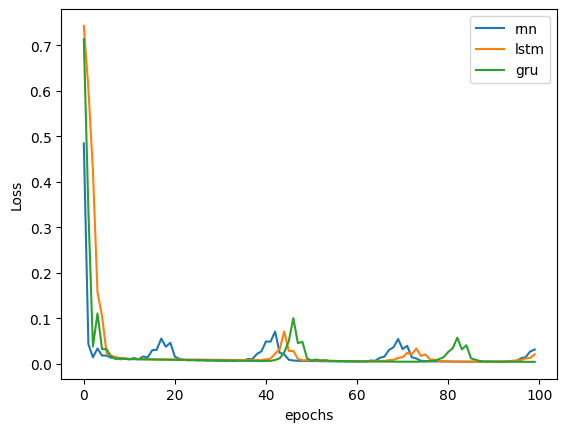

In [392]:
plt.plot(rnn_train_losses,label='rnn')
plt.plot(lstm_train_losses,label='lstm')
plt.plot(gru_train_losses,label='gru')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

# Influence of numbers of lstm

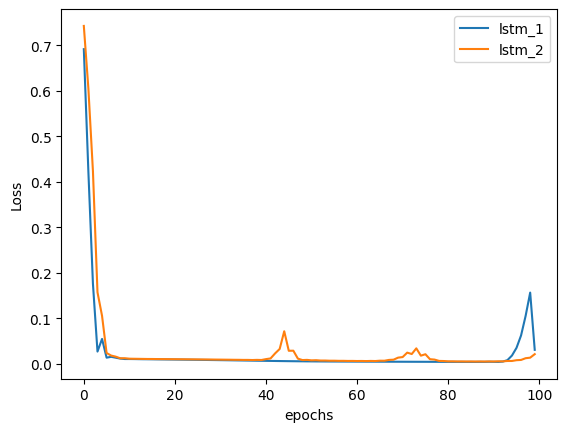

In [395]:
plt.plot(lstm_train_losses1,label='lstm_1')
plt.plot(lstm_train_losses,label='lstm_2')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

# Model predictions

In [386]:

def predict(model, data_loader):
    model.eval()  
    predictions = []
    with torch.no_grad():
        for data, _ in data_loader:
            output = model(data)
            predictions.extend(output.view(-1).tolist())
    return predictions


def plot_predictions(train_preds, valid_preds, train_targets, valid_targets, title):
    plt.figure(figsize=(15, 5))
    r2=r2_score(train_preds, train_targets)

    plt.subplot(1, 2, 1)
    plt.plot(train_targets, label='True')
    plt.plot(train_preds, label='Predicted')
    plt.title(f'{title} - Training Set'+' r2 score='+str(r2))
    plt.legend()
    r2=r2_score(valid_preds, valid_targets)

    plt.subplot(1, 2, 2)
    plt.plot(valid_targets, label='True')
    plt.plot(valid_preds, label='Predicted')
    plt.title(f'{title} - Validation Set'+' r2 score='+str(r2))
    plt.legend()

    plt.show()

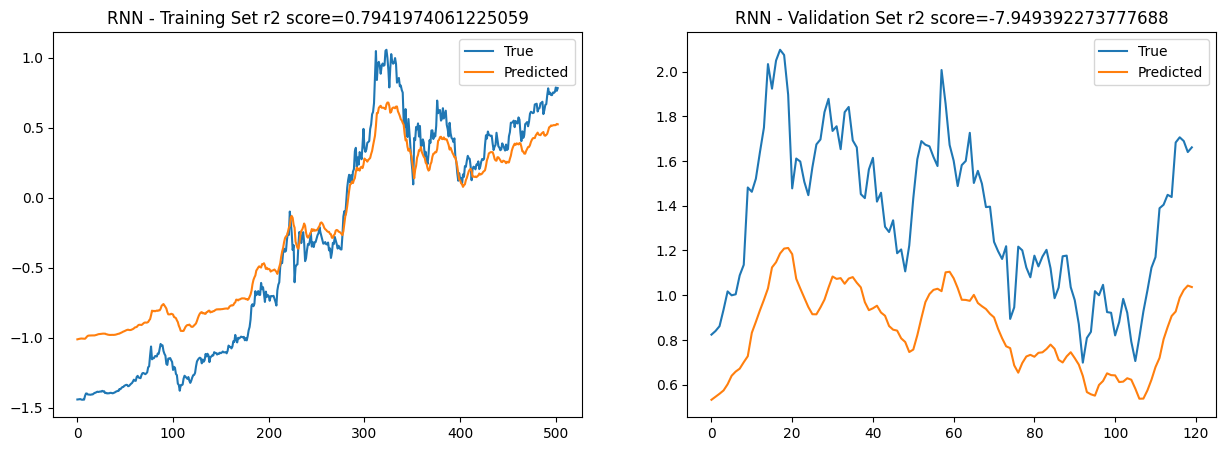

In [387]:

rnn_train_preds = predict(rnn_model, train_loader)
rnn_valid_preds = predict(rnn_model, valid_loader)


plot_predictions(rnn_train_preds, rnn_valid_preds, y_train.tolist(), y_valid.tolist(), "RNN")

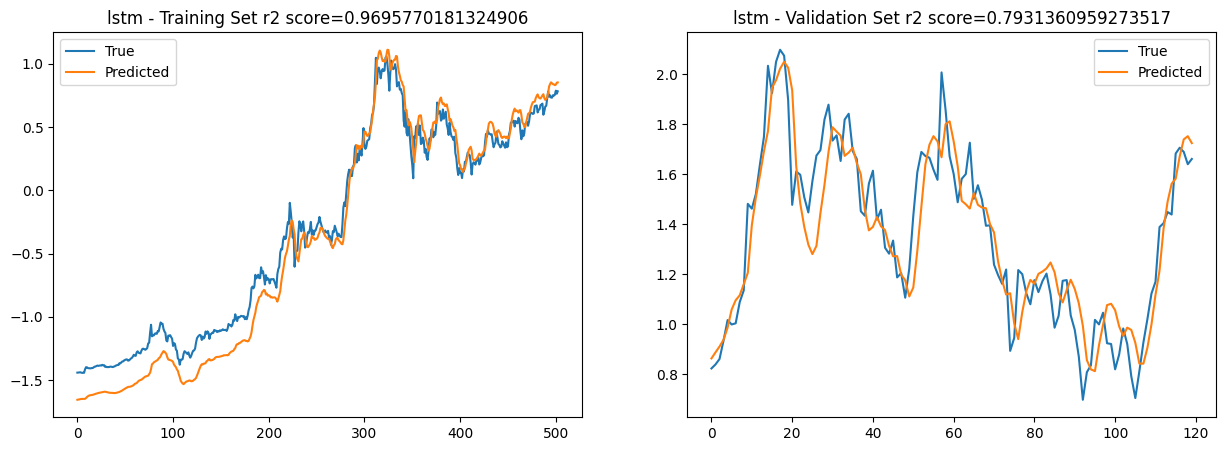

In [388]:

lstm_train_preds = predict(lstm_model, train_loader)
lstm_valid_preds = predict(lstm_model, valid_loader)


plot_predictions(lstm_train_preds, lstm_valid_preds, y_train.tolist(), y_valid.tolist(), "lstm")

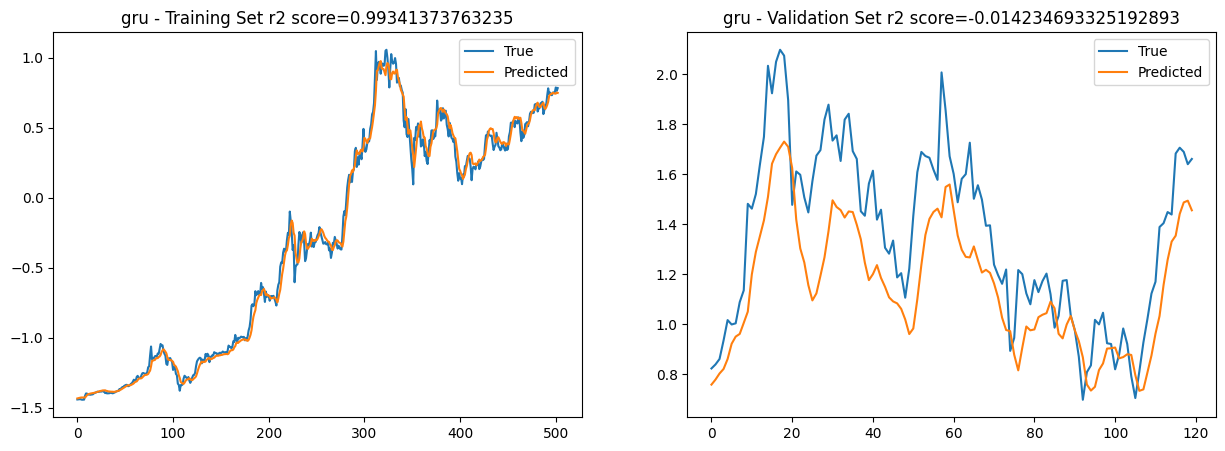

In [389]:

gru_train_preds = predict(gru_model, train_loader)
gru_valid_preds = predict(gru_model, valid_loader)


plot_predictions(gru_train_preds, gru_valid_preds, y_train.tolist(), y_valid.tolist(), "gru")

# Influence of days of history data

In [311]:
def tune_day(day,new_data):
    newdata = series_to_supervised(new_data, 1, day)
    X = newdata.iloc[:,:-1].values
    y = newdata.iloc[:,-1].values
    

    train_size = int(len(newdata) * 0.8)
    valid_size = int(len(newdata) * 0.192)
    test_size = len(newdata) - train_size - valid_size
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(valid_size + test_size)/len(newdata),shuffle=False)
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(valid_size + test_size), shuffle=False)
    
    X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
    X_valid, y_valid = torch.tensor(X_valid, dtype=torch.float32), torch.tensor(y_valid, dtype=torch.float32)
    X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

    batch_size=64
    X_train = X_train.unsqueeze(1)
    X_valid = X_valid.unsqueeze(1)
    X_test = X_test.unsqueeze(1)
    train_loader =  torch.utils.data.DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
    valid_loader =  torch.utils.data.DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=False)
    test_loader =  torch.utils.data.DataLoader(TensorDataset(X_test, y_test), batch_size=1, shuffle=False)

    input_dim = X_train.shape[-1]
    hidden_dim = 100
    layer_dim = 2
    output_dim = 1
    
    rnn_model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim, model_type="LSTM")


    num_epochs =100
    rnn_train_losses, rnn_valid_losses = train_and_validate(rnn_model, train_loader, valid_loader, num_epochs)
    
    mse1,predictions=recursion(rnn_model,test_loader,X_test,y_test,X_train)
    plt.plot(scaler1.inverse_transform(y_test.reshape(-1,1)), label='True')
    plt.plot(scaler1.inverse_transform(np.array(predictions).reshape(-1,1)), label='Predicted')
    plt.legend()
    print(mse1)
    plt.show()



    rnn_valid_preds = predict(rnn_model, valid_loader)
    r2=r2_score(rnn_valid_preds,y_valid)
    mse2=mean_squared_error(rnn_valid_preds,y_valid)
    print(mse2)

    return mse1,mse2,r2


def recursion(rnn_model,test_loader,X_test,y_test,X_train):
    initial_data, _ = next(iter(test_loader))
    

    steps = len(X_test)   
    
    rnn_model.eval()
    #lstm_model.eval()
    predictions = []
    input_data = initial_data.clone()
    
    for _ in range(steps):
        with torch.no_grad():
            prediction = rnn_model(input_data)
            predictions.append(prediction.item())
    
            input_data = input_data[0, 0,1:].data.numpy().tolist()
    
            for i in prediction[0].data.numpy().tolist():
                input_data.append(i)
            input_data = torch.tensor(np.array(input_data).reshape(-1, X_train.shape[-1]), dtype=torch.float32).unsqueeze(1)
    
    return mean_squared_error(predictions,y_test),predictions


def train_and_validate(model, train_loader, valid_loader, num_epochs):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    
    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for data, target in train_loader:
        
            optimizer.zero_grad()
    
            output = model(data)
   
            loss = criterion(output, target.unsqueeze(1))

            loss.backward()

            optimizer.step()
            train_loss += loss.item() * data.size(0)
        

        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
 
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for data, target in valid_loader:
                output = model(data)
                loss = criterion(output, target.unsqueeze(1))
                valid_loss += loss.item() * data.size(0)
        

        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_losses.append(valid_loss)
    return train_losses, valid_losses


2
0.15900035114619251


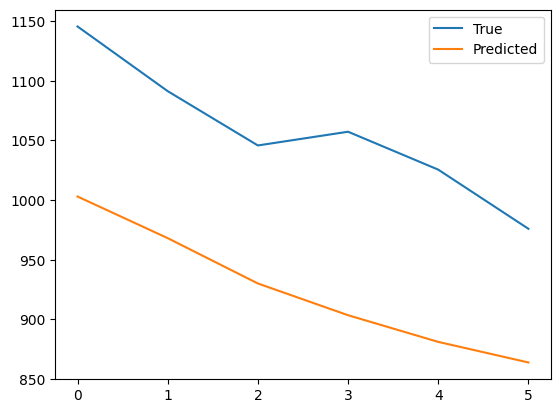

0.048091719512686336
3
0.053969097650375865


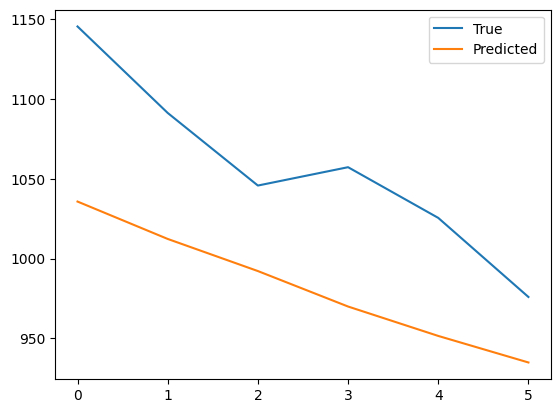

0.03167947366498549
4
0.07853306855378861


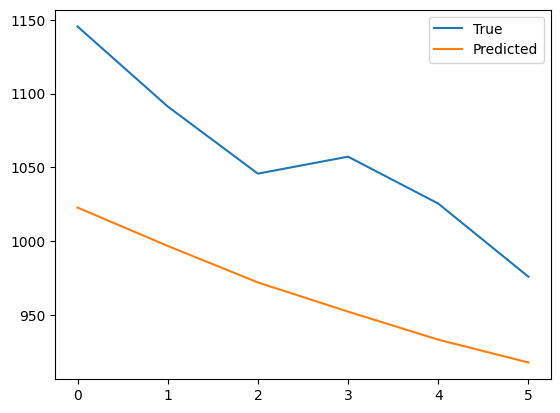

0.03655975173968226
5
0.04029171853472965


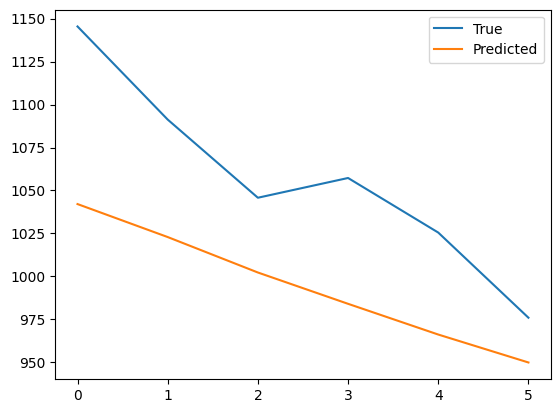

0.029983301036239463
6
0.04078428426390938


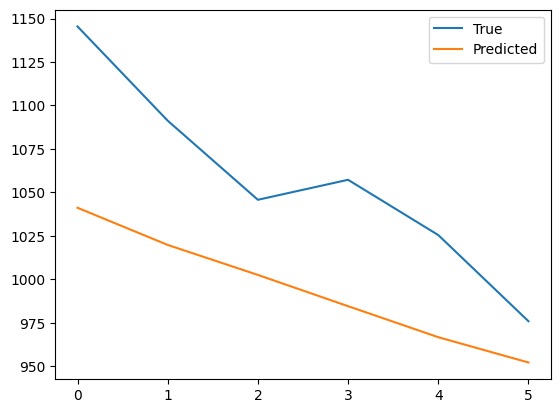

0.029879249548932788
7
0.042555992800920706


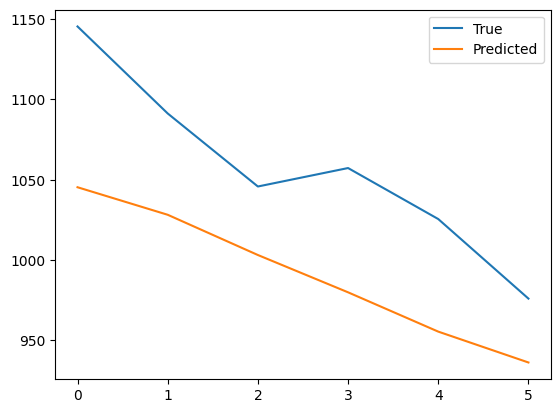

0.02973586694071217
8
0.05180982757205518


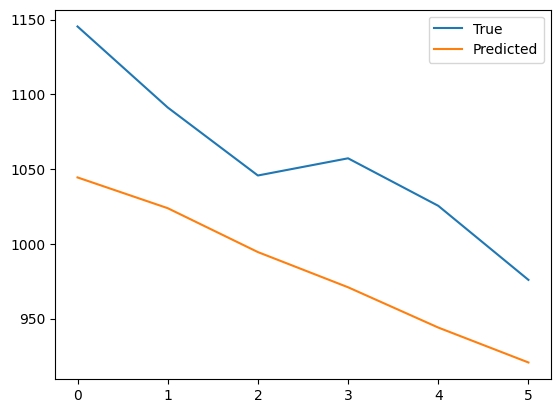

0.03260704320108752
9
0.02274351605078806


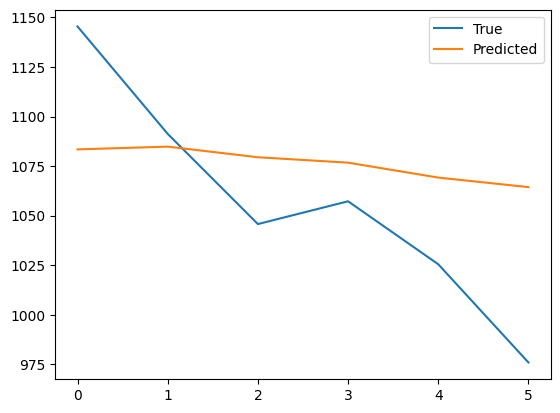

0.020229437118512758
10
0.02910222374617888


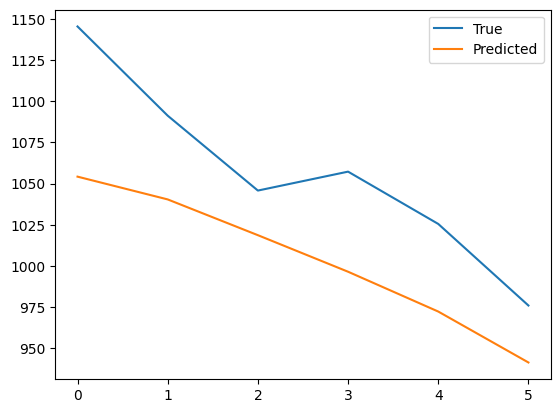

0.03347950697228077
11
0.011913599817186574


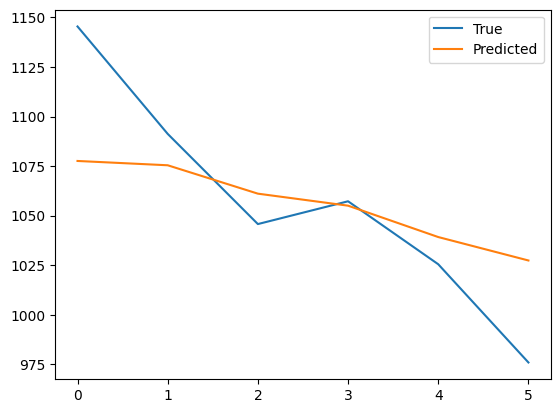

0.02437406454073825
12
0.09480048207108638


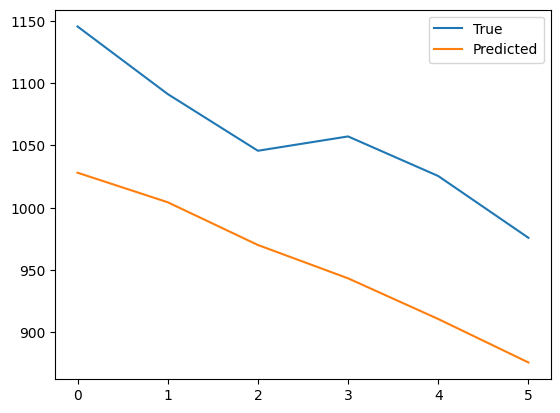

0.05525657210793966
13
0.04716636535079507


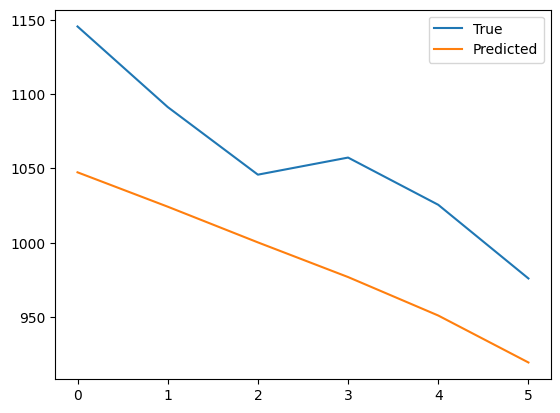

0.04673414540933661
14
0.002145381399878943


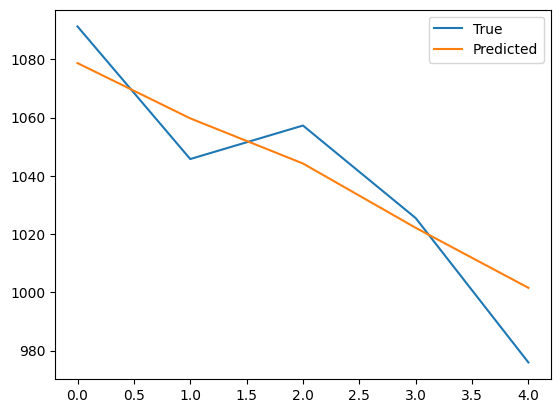

0.04130025424277474
15
0.02937774396689008


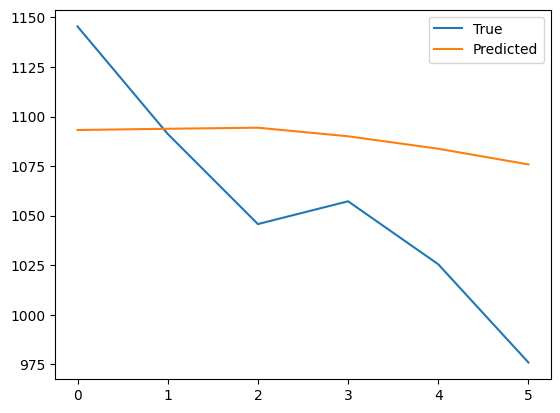

0.026285156002114875
16
0.033306616637290176


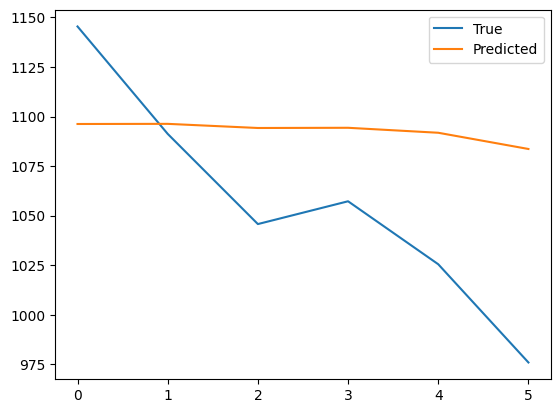

0.028515438834030512
17
0.03558715881584599


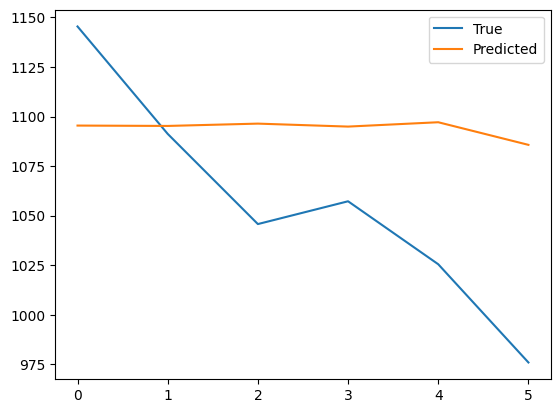

0.030084838335614823
18
0.018569866425904042


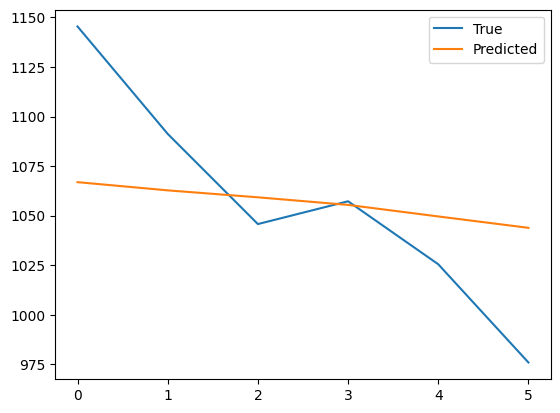

0.028219647962649325
19
0.026339166204704157


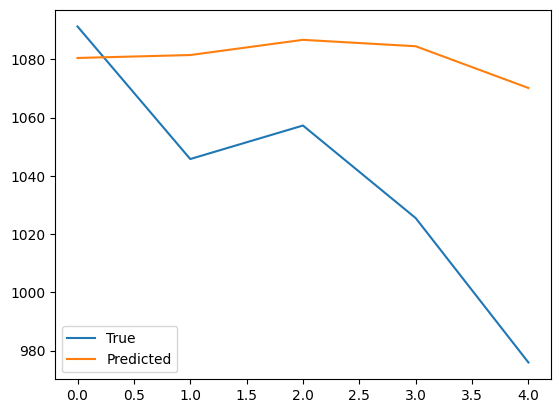

0.033094066162211576


In [301]:
days=range(2,20)
mses=[]
r2s=[]
for day in days:
    print(day)
    mse1,mse2,r2=tune_day(day,new_data)
    mses.append(mse2)
    r2s.append(r2)

Text(0, 0.5, 'mse')

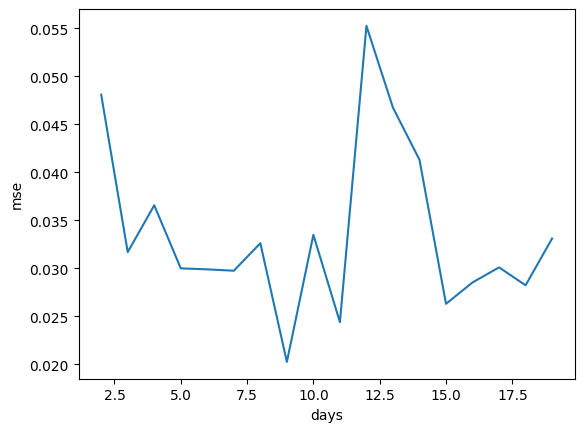

In [302]:
plt.plot(days,mses)
plt.xlabel('days')
plt.ylabel('mse')

Text(0, 0.5, 'r2')

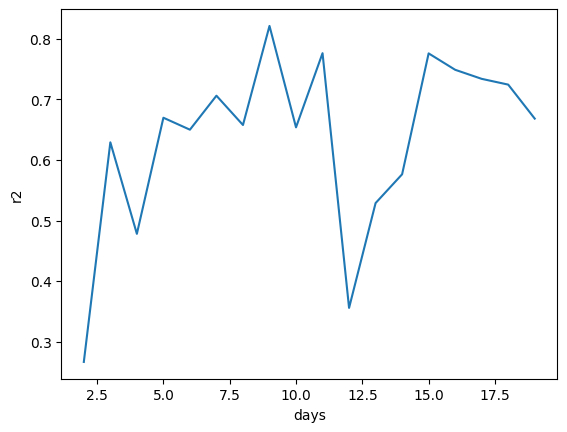

In [303]:
plt.plot(days,r2s)
plt.xlabel('days')
plt.ylabel('r2')